In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold 
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.metrics import mean_squared_error, r2_score
import xgboost
# Import module

from sklearn.metrics import explained_variance_score


  <font size="+2">**Importing Data Set**</font>

The objective being the prediction of prices for different real estate values, we will be tailoring our data around that.

In [2]:
data = pd.read_excel('../input/AgencyDataset/AgencyDataset.xlsx')
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02,313000.0,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02,2384000.0,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02,342000.0,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02,420000.0,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02,550000.0,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


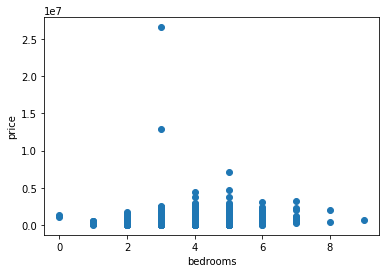

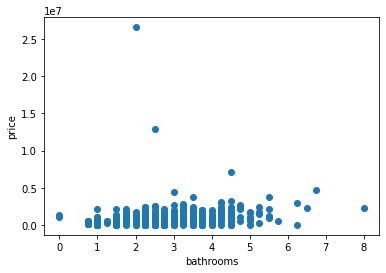

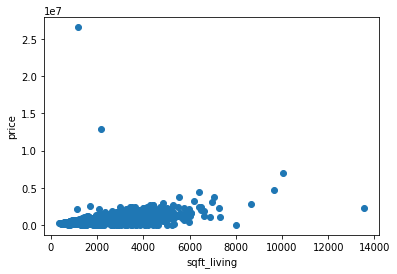

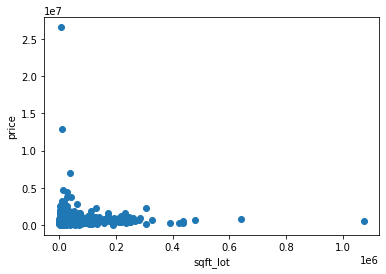

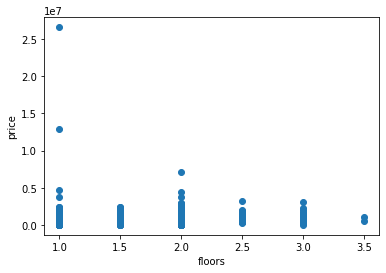

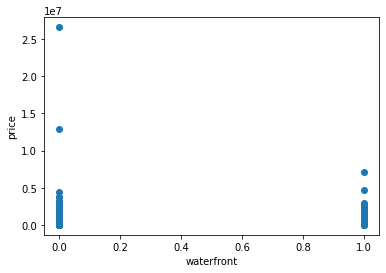

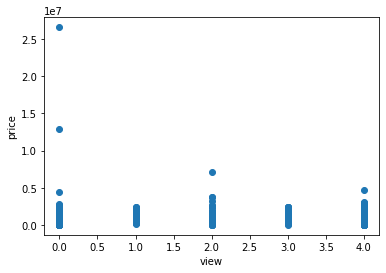

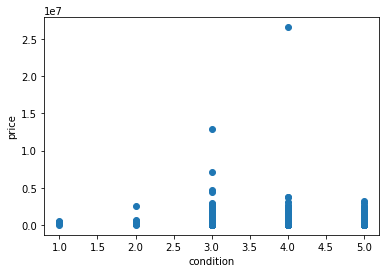

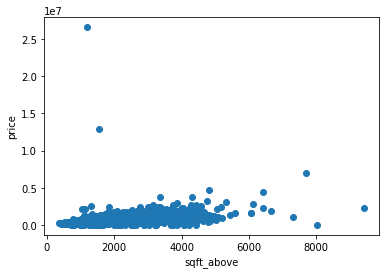

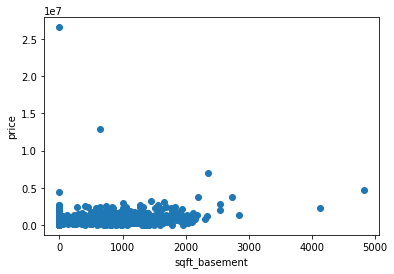

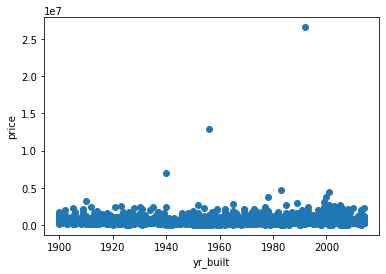

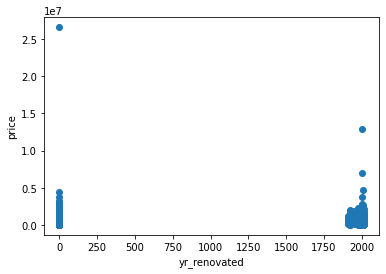

In [3]:
# Visualization -73
labels = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
y = 'price'
for i in range(len(labels)):
    plt.figure()
    plt.scatter(data[labels[i]], data[y])
    plt.xlabel(labels[i])
    plt.ylabel(y)

In [4]:
data["price"].describe()

count    4.600000e+03
mean     5.519630e+05
std      5.638347e+05
min      0.000000e+00
25%      3.228750e+05
50%      4.609435e+05
75%      6.549625e+05
max      2.659000e+07
Name: price, dtype: float64

In [5]:
# Check for duplicated rows
print("Number of duplicate rows: ", sum(data.duplicated()))

Number of duplicate rows:  0


In [6]:
count = (data['price'] == 0).sum()
print('Count of zeros in Column price : ', count)

Count of zeros in Column price :  49


In [7]:
price_max=data.index[data['price']>25000000].tolist()

price_max

[4350]

In [8]:
data.head(4351).tail()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4346,2014-06-23,12899000.0,3,2.50,2190,11394,1.0,0,0,3,1550,640,1956,2001,5426 40th Ave W,Seattle,WA 98199,USA
4347,2014-05-08,2110000.0,4,1.00,2100,9200,1.0,0,0,3,1050,1050,1959,1989,14070 Military Rd S,Tukwila,WA 98168,USA
4348,2014-05-05,2199900.0,4,1.50,1120,5427,1.0,0,0,3,1120,0,1969,2014,19009-19021 SE 266th St,Covington,WA 98042,USA
4349,2014-05-14,188000.0,4,2.75,3260,19542,1.0,0,0,4,2170,1090,1968,0,1525 79th Pl NE,Medina,WA 98039,USA
4350,2014-07-03,26590000.0,3,2.00,1180,7793,1.0,0,0,4,1180,0,1992,0,12005 SE 219th Ct,Kent,WA 98031,USA


In [9]:
data=data.drop(price_max, axis=0)

In [10]:
price_max2=data.index[data['price']>10000000].tolist()

price_max2

[4346]

In [11]:
data.head(4347).tail()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4342,2014-05-20,291000.0,3,1.75,1560,9788,1.0,0,0,3,1560,0,1964,2000,12816 84th Ave S,Seattle,WA 98178,USA
4343,2014-06-16,230000.0,3,1.75,1400,6956,1.0,0,0,4,1400,0,1957,2001,10642 SE 200th St,Kent,WA 98031,USA
4344,2014-05-22,850000.0,4,3.25,3090,6744,2.0,0,4,3,3090,0,2013,1923,19117-19123 Richmond Beach Dr NW,Shoreline,WA 98177,USA
4345,2014-06-01,84350.0,4,2.00,2630,16475,2.0,0,0,4,2630,0,1953,1983,9033 NE 32nd St,Yarrow Point,WA 98004,USA
4346,2014-06-23,12899000.0,3,2.50,2190,11394,1.0,0,0,3,1550,640,1956,2001,5426 40th Ave W,Seattle,WA 98199,USA


In [12]:
data=data.drop(price_max2, axis=0)

In [13]:
price_null=data.index[data['price'] == 0].tolist()
price_null

[4354,
 4356,
 4357,
 4358,
 4361,
 4362,
 4374,
 4376,
 4382,
 4383,
 4385,
 4386,
 4389,
 4394,
 4405,
 4408,
 4411,
 4412,
 4413,
 4420,
 4442,
 4448,
 4453,
 4454,
 4472,
 4478,
 4479,
 4480,
 4481,
 4487,
 4499,
 4507,
 4509,
 4520,
 4521,
 4522,
 4523,
 4528,
 4534,
 4542,
 4552,
 4554,
 4555,
 4558,
 4563,
 4567,
 4574,
 4575,
 4588]

In [14]:
data = data.drop(price_null, axis=0)

In [15]:
count = (data['price'] == 0).sum()
print('Count of zeros in Column price : ', count)

Count of zeros in Column price :  0


  <font size="+2">**Data Cleaning**</font>

First & foremost, check for na data.

In [16]:
data.isna().sum()
#Value might change after encoding object types

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

We will be dropping the date collumn from the Data as it's irrelevent to the price prediction!

In [17]:
data = data.drop(['date'], axis = 1)
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,313000.0,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2384000.0,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,342000.0,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,420000.0,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,550000.0,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [18]:
data["country"].nunique()

1

In [19]:
data[['state','zip_code']] = data.statezip.str.split(" ",expand=True,)
data['state'].nunique()
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,state,zip_code
0,313000.0,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA,WA,98133
1,2384000.0,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA,WA,98119
2,342000.0,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA,WA,98042
3,420000.0,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA,WA,98008
4,550000.0,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA,WA,98052


As we checked, country only possessed 1 value so we're gonna drop it.
Seperating statezip into 2 features also shows that WA is the only state we're working with here so we're gonna keep just the numerical value to avoid having to encode it.
We're also dropping the street collumn as it seems irrelevent.

In [20]:
data=data.drop(['country','state','statezip'],axis=1)


In [21]:
data=data.drop(['street'],axis=1)


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4549 entries, 0 to 4599
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4549 non-null   float64
 1   bedrooms       4549 non-null   int64  
 2   bathrooms      4549 non-null   float64
 3   sqft_living    4549 non-null   int64  
 4   sqft_lot       4549 non-null   int64  
 5   floors         4549 non-null   float64
 6   waterfront     4549 non-null   int64  
 7   view           4549 non-null   int64  
 8   condition      4549 non-null   int64  
 9   sqft_above     4549 non-null   int64  
 10  sqft_basement  4549 non-null   int64  
 11  yr_built       4549 non-null   int64  
 12  yr_renovated   4549 non-null   int64  
 13  city           4549 non-null   object 
 14  zip_code       4549 non-null   object 
dtypes: float64(3), int64(10), object(2)
memory usage: 568.6+ KB


As we can see, we need to encode the zip_code & city.
Note 1: We could convert zip_code to a 16bit integer value but that could lead to wrong assumptions by the model so adding a dict & encoding seems to be the best solution for now.

In [23]:
from sklearn.preprocessing import LabelEncoder
print('Categorical columns: ')
for col in data.columns:
    if data[col].dtype == 'object':
        values = data[col].value_counts()
        values = dict(values)
        
        print(str(col))
        label = LabelEncoder()
        label = label.fit(data[col])
        data[col] = label.transform(data[col].astype(str))
        
        new_values = data[col].value_counts()
        new_values = dict(new_values)
        
        value_dict = {}
        i=0
        for key in values:
            value_dict[key] = list(new_values)[i]
            i+= 1
        print(value_dict)

Categorical columns: 
city
{'Seattle': 35, 'Renton': 32, 'Bellevue': 3, 'Redmond': 31, 'Kirkland': 19, 'Issaquah': 16, 'Kent': 18, 'Auburn': 1, 'Sammamish': 33, 'Federal Way': 14, 'Shoreline': 36, 'Woodinville': 42, 'Maple Valley': 21, 'Mercer Island': 23, 'Burien': 6, 'Snoqualmie': 38, 'Kenmore': 17, 'Des Moines': 10, 'North Bend': 27, 'Duvall': 11, 'Covington': 9, 'Lake Forest Park': 20, 'Bothell': 5, 'Newcastle': 25, 'Tukwila': 40, 'Vashon': 41, 'SeaTac': 34, 'Enumclaw': 12, 'Carnation': 7, 'Normandy Park': 26, 'Fall City': 13, 'Medina': 22, 'Clyde Hill': 8, 'Black Diamond': 4, 'Ravensdale': 30, 'Pacific': 28, 'Algona': 0, 'Yarrow Point': 43, 'Skykomish': 37, 'Preston': 29, 'Milton': 24, 'Inglewood-Finn Hill': 15, 'Snoqualmie Pass': 39, 'Beaux Arts Village': 2}
zip_code
{'98103': 47, '98052': 31, '98117': 56, '98115': 54, '98006': 5, '98059': 37, '98034': 22, '98042': 26, '98053': 32, '98038': 23, '98058': 36, '98027': 15, '98074': 42, '98023': 13, '98133': 62, '98033': 21, '98125':

In [24]:
data.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
city             0
zip_code         0
dtype: int64

Okay so even after encoding, no non available or duplicates seem to appear so mostly cleaned data.

  <font size="+2">**Data Analysis**</font>

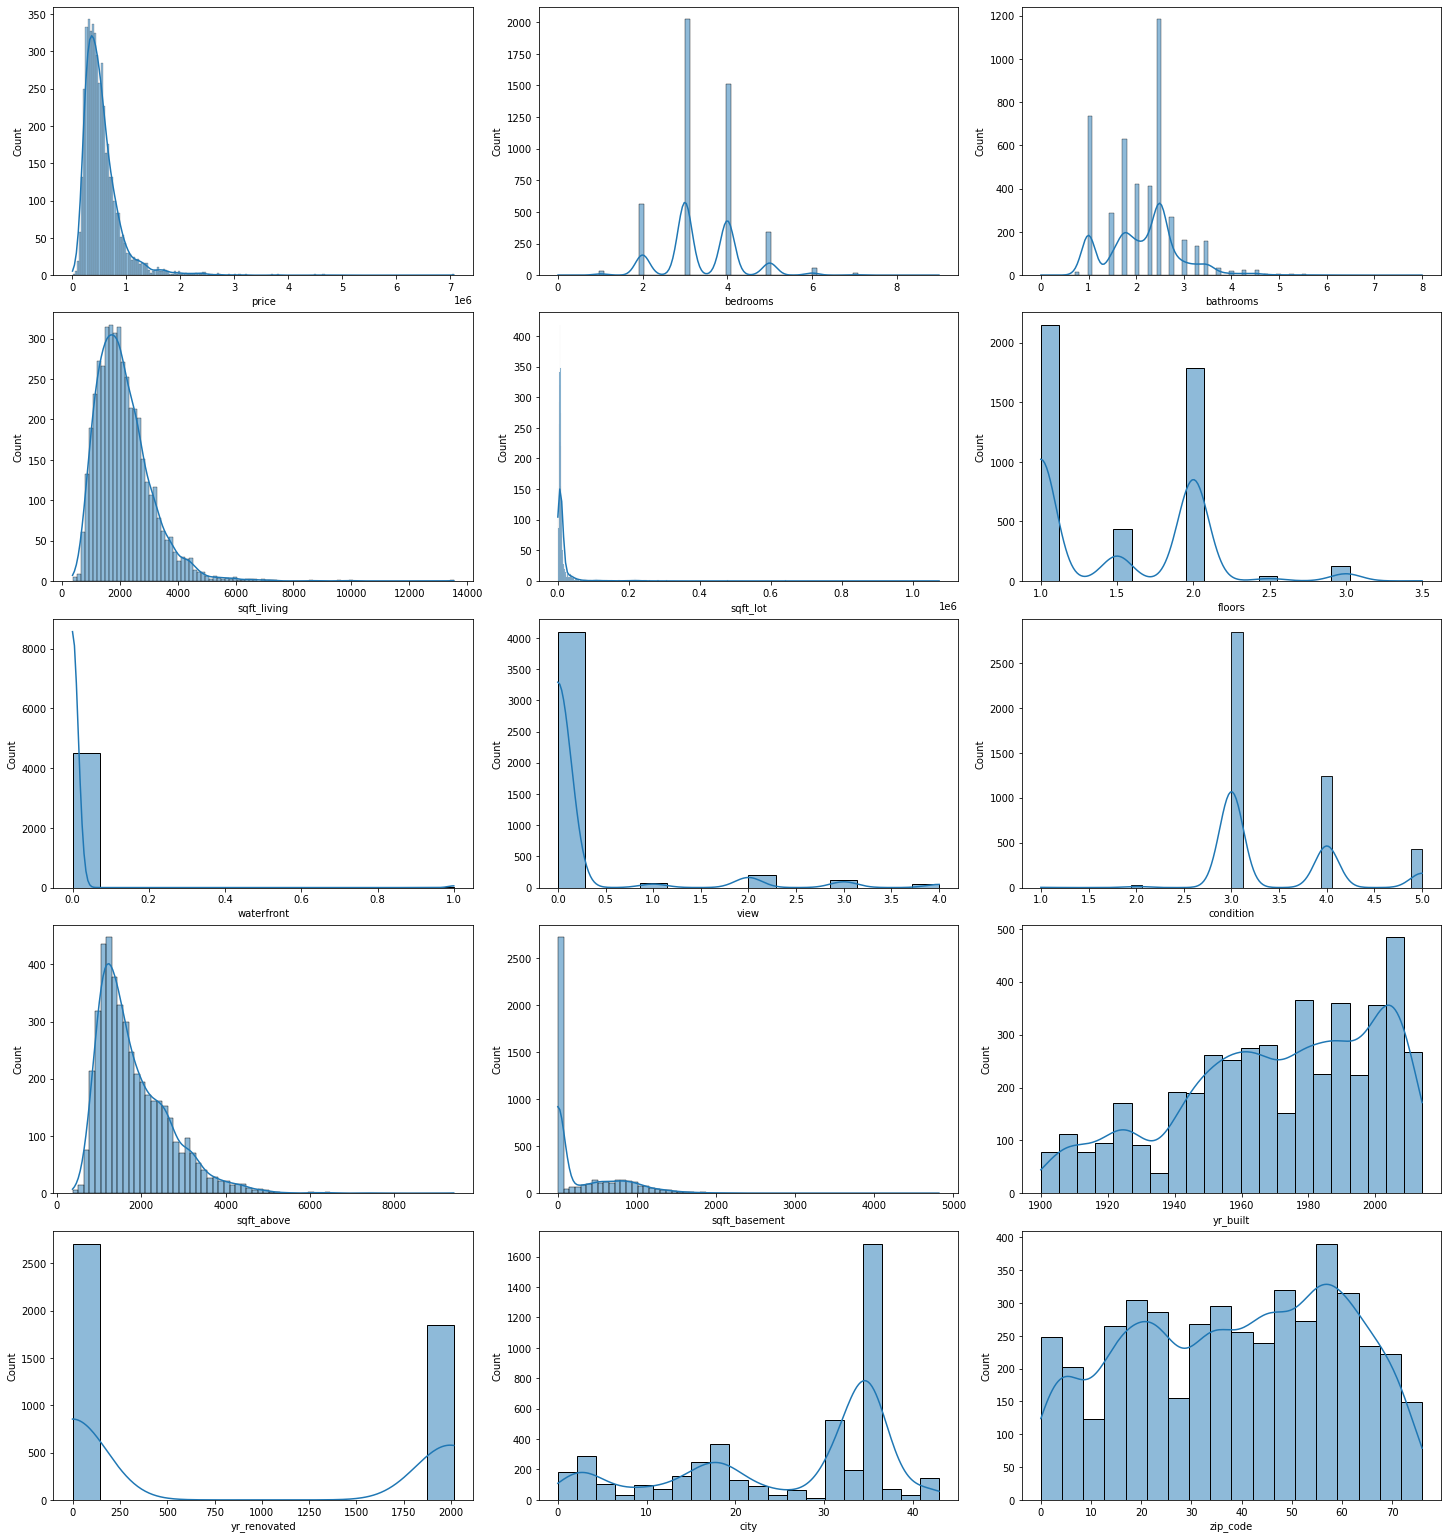

In [25]:
# Graph each variable's distribution
fig = plt.figure(figsize=(20, 25), constrained_layout=True)
for i in range(len(data.columns)):
    plt.subplot(6, 3, i+1)
    sns.histplot(data=data, x=data[data.columns[i]], kde=True)

With this figure, we can get an approximate estimation to the mean of each feature & therefore know which majority is in which interval.

But what we need to know is the correlation of each feature with the price.

Since the target feature is price, we will correlate all other features to it.

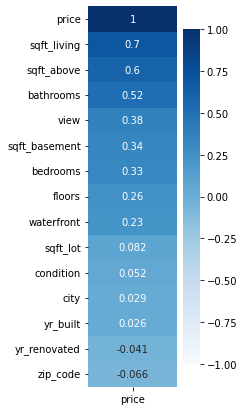

In [26]:
# Correlating features with target
plt.figure(figsize=(2, 7))
heatmap = sns.heatmap(data.corr()[['price']]
                      .sort_values(by='price', ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap='Blues')

As we can see, price has its strongest correlations with sqft_living,sqft_above and bathrooms

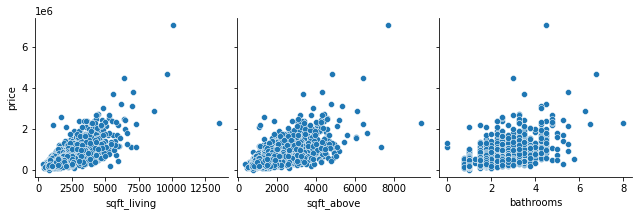

In [27]:
# Pairplot variable target with strong correlation variables target -with
sns.pairplot(data, x_vars=['sqft_living', 'sqft_above', 'bathrooms'],
             y_vars=['price'], height=3, aspect=1)



Based on the pairplot above, we can see that :

the higher each variable is, the higher the price is.
We can see 2 points that are too far away from the clusters, we can assume those are clusters or VERY particular data.

In [28]:
# Define df_1
data = (data.loc[:, ~data.columns.isin(['lat', 'long'])]).round(0).astype(int)
data.head(5)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,zip_code
0,313000,3,2,1340,7912,2,0,0,3,1340,0,1955,2005,36,62
1,2384000,5,2,3650,9050,2,0,4,5,3370,280,1921,0,35,58
2,342000,3,2,1930,11947,1,0,0,4,1930,0,1966,0,18,26
3,420000,3,2,2000,8030,1,0,0,4,1000,1000,1963,0,3,7
4,550000,4,2,1940,10500,1,0,0,4,1140,800,1976,1992,31,31


In [29]:
# Describe the small amount variable
sav = data[(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition'])]

In [30]:
price_max3=data.index[data['bathrooms']==7].tolist()

price_max3

[2654]

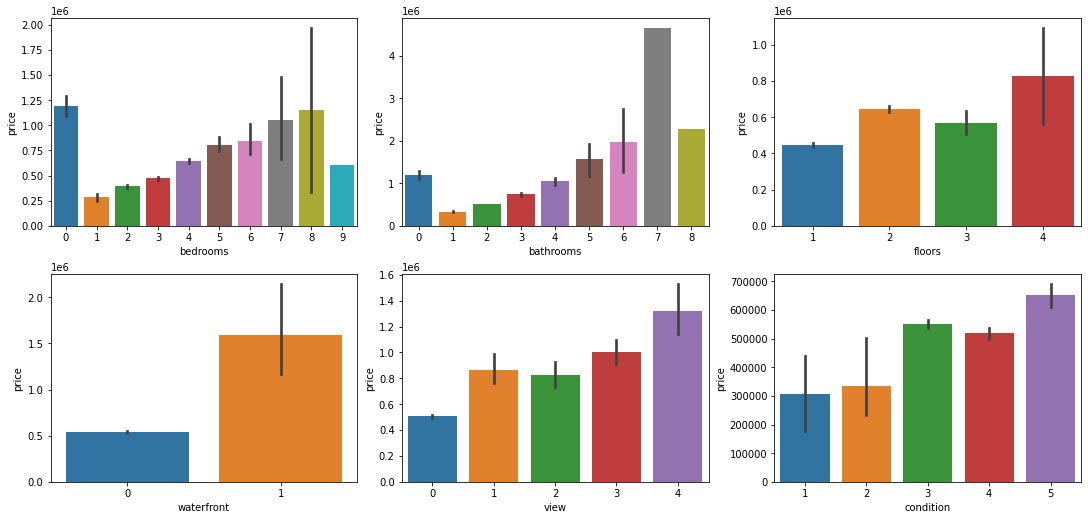

In [31]:

fig = plt.figure(figsize=(15,10), constrained_layout=True)
for i in range(len(sav.columns)):
    plt.subplot(3, 3, i+1)
    sns.barplot(data=sav, x=sav[sav.columns[i]], y=data['price'])

In [32]:
data.index[data['bedrooms'] == 0].tolist()

[2365, 3209]

In [33]:
data.head(2655).tail()


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,zip_code
2650,379900,5,4,2800,7350,2,0,0,3,2800,0,1995,0,35,49
2651,738500,3,2,2300,6009,1,0,0,3,2300,0,2005,0,31,32
2652,545000,4,2,2030,11585,1,0,0,4,1590,440,1967,0,31,31
2653,342000,2,1,740,6180,1,0,0,3,740,0,1948,1994,35,57
2654,4668000,5,7,9640,13068,1,1,4,3,4820,4820,1983,2009,23,25


What we can take away from this are 2 things: 
The 0 bedroom places's value must be the occurance of a lot of outliers since no way a 0 bedroom home is higher praced than a 7-8 one.
Bathroom value seems accurate except for 2 things, the 0 bathroom value is too hight as well as the 7 one, we will be checking for outliers for that one too.
The rest seems fine.

In [34]:
bedroom_null=data.index[data['bedrooms'] == 0].tolist()
bedroom_null

[2365, 3209]

In [35]:
data.head(2286).tail()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,zip_code
2281,290300,2,1,860,3874,1,0,0,4,860,0,1931,0,32,35
2282,527000,2,2,1640,4080,1,0,0,3,840,800,1921,2000,35,48
2283,487028,2,2,1295,1093,2,0,0,3,1105,190,2007,0,35,59
2284,325000,3,2,1790,27427,1,0,0,3,1130,660,1978,0,38,38
2285,799000,3,2,2210,6300,2,0,0,5,2210,0,1916,0,35,64


In [36]:
count = (data['bedrooms'] == 0).sum()
print('Count of zeros in Column price : ', count)

Count of zeros in Column price :  2


In [37]:
data=data.drop(bedroom_null,axis=0)

In [38]:
count = (data['bedrooms'] == 0).sum()
print('Count of zeros in Column price : ', count)

Count of zeros in Column price :  0


In [39]:
data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,zip_code
0,313000,3,2,1340,7912,2,0,0,3,1340,0,1955,2005,36,62
1,2384000,5,2,3650,9050,2,0,4,5,3370,280,1921,0,35,58
2,342000,3,2,1930,11947,1,0,0,4,1930,0,1966,0,18,26
3,420000,3,2,2000,8030,1,0,0,4,1000,1000,1963,0,3,7
4,550000,4,2,1940,10500,1,0,0,4,1140,800,1976,1992,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,308167,3,2,1510,6360,1,0,0,4,1510,0,1954,1979,35,62
4596,534333,3,2,1460,7573,2,0,0,3,1460,0,1983,2009,3,6
4597,416904,3,2,3010,7014,2,0,0,3,3010,0,2009,0,32,37
4598,203400,4,2,2090,6630,1,0,0,3,1070,1020,1974,0,35,71


In [40]:
count = (data['bathrooms'] == 0).sum()
print('Count of zeros in Column price : ', count)

Count of zeros in Column price :  0


In [41]:
data.isnull().any()

price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
city             False
zip_code         False
dtype: bool

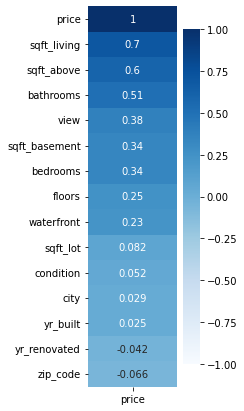

In [42]:
# Correlating features with target
plt.figure(figsize=(2, 7))
heatmap = sns.heatmap(data.corr()[['price']]
                      .sort_values(by='price', ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap='Blues')

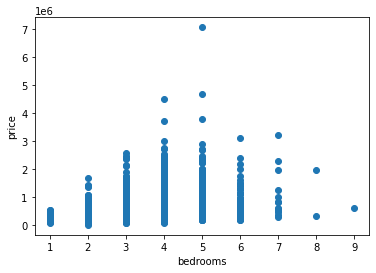

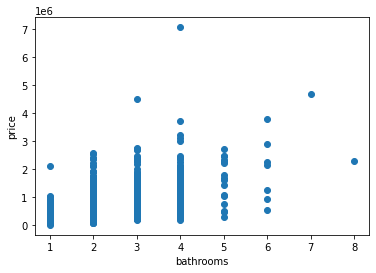

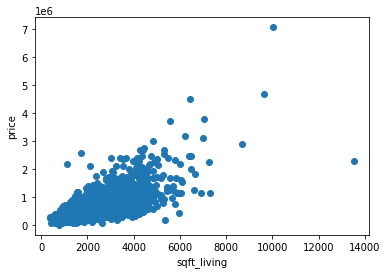

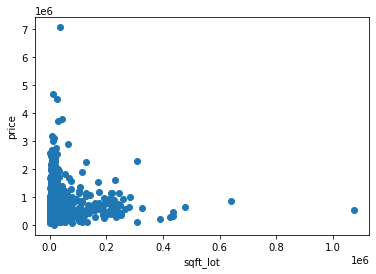

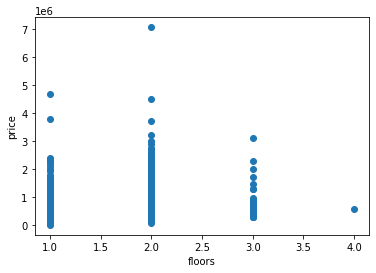

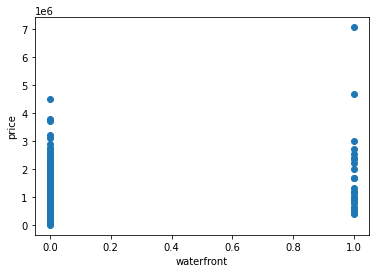

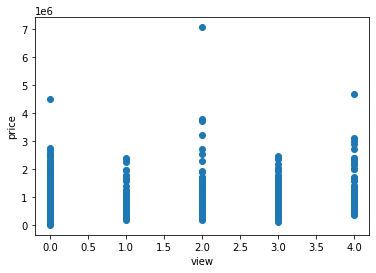

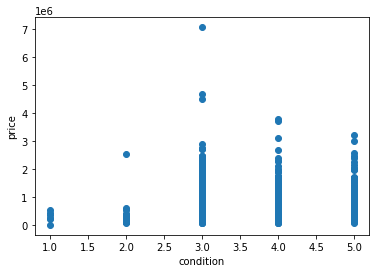

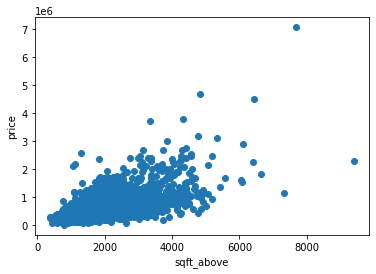

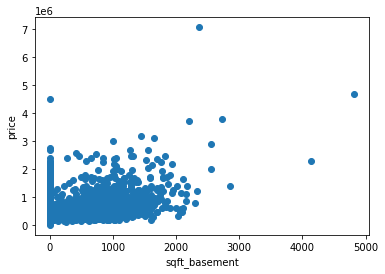

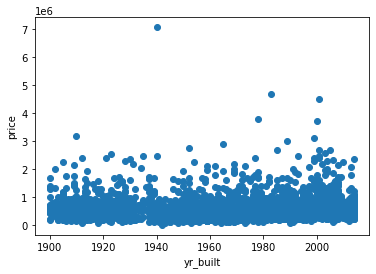

In [43]:
# Visualization -73
labels = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built']
y = 'price'
for i in range(len(labels)):
    plt.figure()
    plt.scatter(data[labels[i]], data[y])
    plt.xlabel(labels[i])
    plt.ylabel(y)

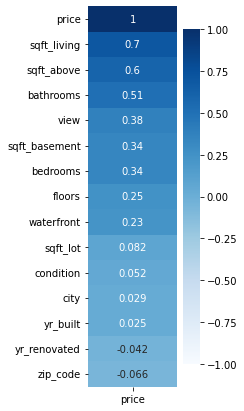

In [44]:
# Correlating features with target
plt.figure(figsize=(2, 7))
heatmap = sns.heatmap(data.corr()[['price']]
                      .sort_values(by='price', ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap='Blues')

In [45]:
price_max3=data.index[data['price']>7000000].tolist()

price_max3

[2286]

In [46]:
data.head(2287).tail()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,zip_code
2282,527000,2,2,1640,4080,1,0,0,3,840,800,1921,2000,35,48
2283,487028,2,2,1295,1093,2,0,0,3,1105,190,2007,0,35,59
2284,325000,3,2,1790,27427,1,0,0,3,1130,660,1978,0,38,38
2285,799000,3,2,2210,6300,2,0,0,5,2210,0,1916,0,35,64
2286,7062500,5,4,10040,37325,2,1,2,3,7680,2360,1940,2001,3,3


In [47]:
data=data.drop(price_max3,axis=0)

<AxesSubplot:>

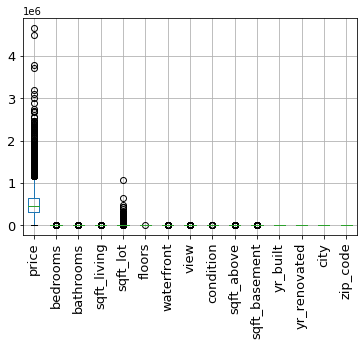

In [48]:
data.boxplot(grid=True, rot=90, fontsize=13)


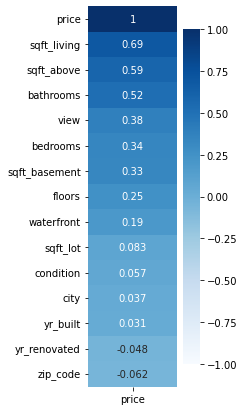

In [49]:
# Correlating features with target
plt.figure(figsize=(2, 7))
heatmap = sns.heatmap(data.corr()[['price']]
                      .sort_values(by='price', ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap='Blues')

In [50]:
df=pd.DataFrame(data)

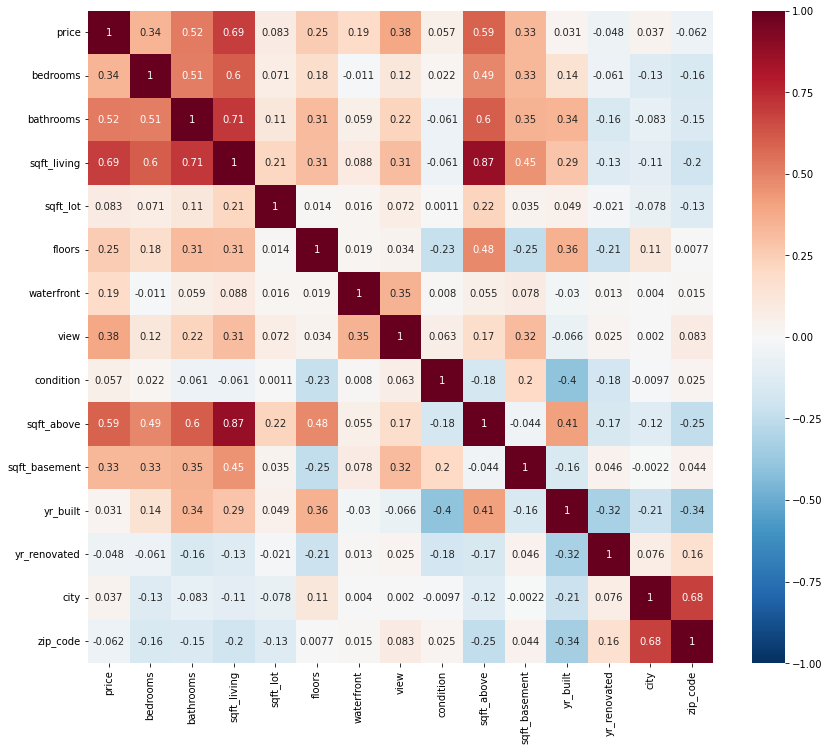

In [51]:
correlation = data.corr()
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

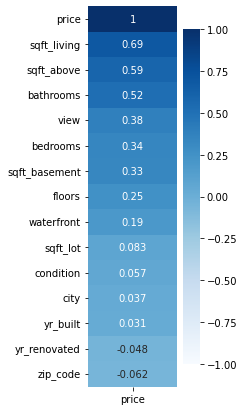

In [52]:
# Correlating features with target
plt.figure(figsize=(2, 7))
heatmap = sns.heatmap(df.corr()[['price']]
                      .sort_values(by='price', ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap='Blues')

In [53]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [54]:
X = df.drop(['price'], axis=1)
y = df[['price']]

model = LinearRegression()

scores = cross_val_score(model, X, y, cv=10)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [0.59005363 0.62569477 0.58157026 0.57552666 0.55577475 0.68597117
 0.58537943 0.57590343 0.60762928 0.27198212]
Average cross-validation score: 0.57


In [55]:
# Data Splitting

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.3, random_state=100)

In [56]:
model.fit(X_train,y_train)

LinearRegression()

In [57]:
# Describe y_predicted
y_predicted=model.predict(X_test)
y_predicted

array([[ 718765.87286578],
       [ 279924.05783981],
       [ 178963.31299165],
       ...,
       [1468390.96376921],
       [ 566521.46990038],
       [ 175672.43302261]])

In [58]:
model.score(X_test,y_test)

0.5861298925057381

In [59]:
# Train sxgboost
xgb = xgboost.XGBRegressor(n_estimators=400, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [60]:
traindf, testdf = train_test_split(X_train, test_size = 0.3)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.08, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [61]:
predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

0.61655202907275
